File Name: bayesian_optimisation_beta 

Description: This notebook experiments with bayesian optimisation to try and optimise the structure of the autoencoder 

In [1]:
import keras
import tensorflow as tf
from keras.layers import LeakyReLU
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

2025-09-04 15:33:18.022046: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-04 15:33:18.070067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-04 15:33:18.070121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-04 15:33:18.071376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-04 15:33:18.078764: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-04 15:33:18.079784: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df = pd.read_csv('../../data/unlabelled_data.csv')
df.drop(columns=['Juniper'], inplace=True)

botanicals = df.iloc[:,25:277]

In [3]:

botanicals

,LD (F),Rosewater,Honey,Lemon Myrtle,Herb-Robert,Camomile,Rose,Jasmine,Passion Flower,Acacia Flower,...,Clementine,Tangerine,Black Lemon,Buddha's Hand,Calamansi,Jaffa Cakes,Treacle,Bee Pollen,Collagen,Angostura Bitters
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super().__init__(**kwargs)
        # Initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        # Initialize metrics to show loss during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    def save_models(self):
        # Save the model to the specified filepath
        self.encoder.save("../../models/trad_arch_encoder.keras")
        self.decoder.save("../../models/trad_arch_decoder.keras")
        


    @property
    def metrics(self):
        # Return the list of metrics to track during training
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            #get the mean, log_var and  from the encoder
            mean,log_var, z = self.encoder(data)
            #! add another layer here that adds the one hot encoded label of the botanicals to the decoder 
            #!info = labeler(data[1] , z)
            reconstruction = self.decoder(z)
            #calculate the reconstruction loss with binary crossentropy
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction),
        
            
            #calculate the KL divergence loss
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            #total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + (self.beta*kl_loss)
            
        # Calculate gradients and apply them to the optimizer
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [5]:
@keras.saving.register_keras_serializable()
class Sampling(keras.layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [6]:
counter = 0

def object_function(x):
        
        df = pd.read_csv('../../data/unlabelled_data.csv')
        df.drop(columns=['Juniper'], inplace=True)

        botanicals = df.iloc[:,25:277]
        
        with open('../../data/json/willies_hehehe.json', 'r') as f:
                kmeans_labels = json.load(f)
         
        beta = x[:, 0]
        # hidden_layer = x[:,1]
        # latent_dim = x[:,2]
        
        
        #build input layer for encoder
        inputs_encoder = keras.Input(botanicals.columns.__len__()) 
        downsample1 = keras.layers.Dense(350, activation=LeakyReLU())
        x_encoder = downsample1(inputs_encoder)

        #build latent space
        mean = keras.layers.Dense(52, activation='linear')(x_encoder)
        log_var = keras.layers.Dense(52, activation='linear')(x_encoder)
        z = Sampling()([mean, log_var])      
        
        #compile encoder model        
        encoder = keras.models.Model(inputs = inputs_encoder, outputs = [mean, log_var, z], name = "encoder")
                
        #build input layer for decoder
        latent_input = keras.Input(52)
        upsampler1 = keras.layers.Dense(350, activation="relu")
        x_decoder = upsampler1(latent_input)
        x_decoder = keras.layers.Dropout(0.2)(x_decoder)
        
        #build output layer for decoder
        constructor = keras.layers.Dense(botanicals.columns.__len__(), activation="sigmoid")
        x_decoder = constructor(x_decoder)
        
        #compile decoder model
        decoder = keras.models.Model(inputs = latent_input, outputs = x_decoder, name = "decoder")
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='loss', save_best_only=True)


        vae = VAE(encoder, decoder, beta)
        vae.compile(optimizer=keras.optimizers.Adam())
        history = vae.fit(botanicals, epochs=50, batch_size=64,  callbacks = (checkpoint, callback))
        
        vectors = encoder.predict(botanicals)
        silhouette = silhouette_score(vectors[0], kmeans_labels["labels"])
        db = davies_bouldin_score(vectors[0], kmeans_labels["labels"])
        
        #disentablgement metric 
        dis_met = (1-silhouette)+(np.log(db+1))
        
        with open('bayes_opt_all_results.txt', 'a+') as report_file:
                report_file.write(f"Silhouette = {silhouette} Davies Bouldin = {db}\n-----------------Beta = {beta}, Loss = {dis_met}\n\n")
        
        return dis_met

In [7]:
# Setting the bounds of network parameter for the bayeyias optimizatio
bounds = [{'name': 'beta', 'type': 'continuous','domain': (0.25, 30)}]

# Creating the GPyOpt method using Bayesian Optimizatio
optimiser = GPyOpt.methods.BayesianOptimization(object_function, 
                                                   domain=bounds)

#Stop conditions
max_time  = None 
max_iter  = 20
tolerance = 0.1


#Running the method
optimiser.run_optimization(max_iter = max_iter,
                            max_time = max_time,
                            eps = tolerance)

with open('bayes_opt_beta.txt', 'a+') as report_file:
    report_file.write("\nNew report")
    report_file.write(f"\nValue of (x,y) that minimises the objective: \nbeta:{optimiser.x_opt[0]}")
    report_file.write("\nMinimum value of the objective: "+str(optimiser.fx_opt))

# print("Value of (x,y) that minimises the objective:"+str(optimiser.x_opt))    
# print("Minimum value of the objective: "+str(optimiser.fx_opt))

Epoch 1/50
9/9 [==============================] - 1s 19ms/step - loss: 0.7876 - reconstruction_loss: 0.5842 - kl_loss: 0.0071
Epoch 2/50
9/9 [==============================] - 0s 16ms/step - loss: 0.4656 - reconstruction_loss: 0.3647 - kl_loss: 0.0033
Epoch 3/50
9/9 [==============================] - 0s 14ms/step - loss: 0.2768 - reconstruction_loss: 0.2238 - kl_loss: 0.0018
Epoch 4/50
9/9 [==============================] - 0s 15ms/step - loss: 0.1826 - reconstruction_loss: 0.1509 - kl_loss: 0.0012
Epoch 5/50
9/9 [==============================] - 0s 16ms/step - loss: 0.1324 - reconstruction_loss: 0.1115 - kl_loss: 8.3462e-04
Epoch 6/50
9/9 [==============================] - 0s 15ms/step - loss: 0.1097 - reconstruction_loss: 0.0949 - kl_loss: 6.1031e-04
Epoch 7/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0967 - reconstruction_loss: 0.0856 - kl_loss: 4.7398e-04
Epoch 8/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0867 - reconstruction_loss: 0.081

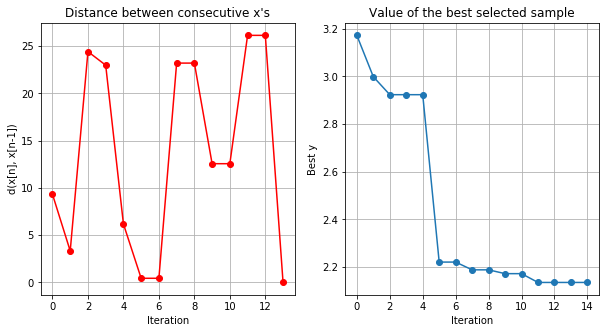

In [8]:
optimiser.plot_convergence()

ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

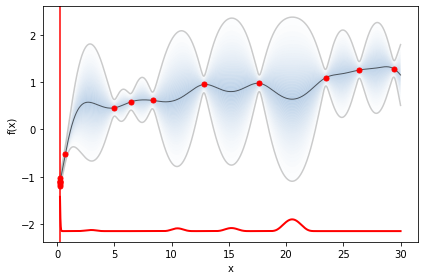

In [9]:
optimiser.plot_acquisition()
